In [310]:
import pandas as pd
import matplotlib.pyplot as plt
from requests import head
import koreanize_matplotlib
import numpy as np

In [311]:
# 파일 불러오기
df_solar = pd.read_csv("data/NASA_solar_radiation.csv")
df_temp = pd.read_excel("data/84_대구온도.xlsx")

# 날짜 변환
df_solar["year"] = pd.to_datetime(df_solar[['year','month', 'day']])

# 기존 컬럼 삭제 및 연도 컬럼 추가
df_solar = df_solar.drop(columns=['month', 'day'])
#df_solar["year"] = df_solar["year"].dt.year


# 11월과 12월 데이터만 필터링
#df_solar = df_solar[df_solar['year'].dt.month.isin([11, 12])]
print(df_solar)

# 연도별로 그룹화하여 평균 계산
df_solar = df_solar.groupby(df_solar['year'].dt.year)[['radiation_long','radiation_short']].mean().reset_index()
print(df_solar)

            year  radiation_short  radiation_long   temp
0     1984-01-01             2.98            5.00  -4.32
1     1984-01-02             2.67            5.86  -1.83
2     1984-01-03             2.14            6.09  -2.14
3     1984-01-04             3.14            4.69  -7.25
4     1984-01-05             3.22            4.67 -10.30
...          ...              ...             ...    ...
14971 2024-12-27             2.58            5.27  -4.40
14972 2024-12-28             2.65            4.99  -5.33
14973 2024-12-29             2.59            5.49  -1.81
14974 2024-12-30             1.73            6.98   1.76
14975 2024-12-31             2.64            5.56  -0.71

[14976 rows x 4 columns]
    year  radiation_long  radiation_short
0   1984        7.761120         4.048115
1   1985        7.793616         4.167890
2   1986        7.607288         4.305781
3   1987        7.744575         4.048548
4   1988        7.746311         4.076038
5   1989        7.748932         4.077

In [312]:
## 온도 데이터 날짜 변환 및 연도 추출
#df_temp["year"] = df_temp["날짜"].dt.year

## 연도별 최저 기온 계산
#df_temp_yearly = df_temp.groupby("year")[["최저기온(℃)"]].mean().reset_index()

## 연도 값을 정수형으로 변환
#df_temp_yearly["year"] = df_temp_yearly["year"].astype(int)

#display(df_temp_yearly.tail())

# 단파 에너지, 장파 에너지 연도랑 그룹화
df_solar_short = df_solar.groupby("year")[['radiation_short']].mean().reset_index()
df_solar_long = df_solar.groupby("year")[['radiation_long']].mean().reset_index()

print(df_solar_short.head())
print(df_solar_long.head())


   year  radiation_short
0  1984         4.048115
1  1985         4.167890
2  1986         4.305781
3  1987         4.048548
4  1988         4.076038
   year  radiation_long
0  1984        7.761120
1  1985        7.793616
2  1986        7.607288
3  1987        7.744575
4  1988        7.746311


In [313]:
# 기온이 5도 이하로 5일 이상 지속되는 첫날을 겨울 시작일로 정의
winter_start_dates = []

# 각 연도에 대해 반복
for year in df_temp["날짜"].dt.year.unique():
    # 해당 연도 데이터만 필터링
    df_year = df_temp[df_temp["날짜"].dt.year == year]
    
    # 11월과 12월만 필터링
    #december_data = df_year[df_year["날짜"].dt.month == 12]
    november_december_data = df_year[df_year["날짜"].dt.month.isin([11, 12])]

    
    # 9일 연속으로 기온이 5도 이하로 지속되는 구간 찾기
    consecutive_days = 0
    for i in range(1, len(november_december_data)):
        if november_december_data.iloc[i]["최저기온(℃)"] <= 5:
            consecutive_days += 1
        else:
            consecutive_days = 0
        
        # 5일 연속 기온 하강 구간에서 첫 번째 날을 겨울 시작일로 정의
        if consecutive_days == 9:  # 9일 연속으로 기온이 하강했을 때 첫 날을 겨울 시작일로 설정
            winter_start_dates.append({"year": year, "winter_start": november_december_data.iloc[i]["날짜"]})
            break


# 결과를 데이터프레임으로 변환
df_winter_start = pd.DataFrame(winter_start_dates)


df_winter_start

,year,winter_start
0,1984,1984-12-03
1,1985,1985-11-19
2,1986,1986-11-23
3,1987,1987-12-06
4,1988,1988-11-23
5,1989,1989-11-19
6,1990,1990-12-09
7,1991,1991-11-19
8,1992,1992-12-02
9,1993,1993-11-29


In [314]:
# 겨울 시작일에 해당하는 주차(week number) 계산하여 DataFrame에 추가
df_winter_start['week'] = pd.to_datetime(df_winter_start['winter_start']).dt.isocalendar().week

# 결과 출력
df_winter_start[['year', 'week']]

,year,week
0,1984,49
1,1985,47
2,1986,47
3,1987,49
4,1988,47
5,1989,46
6,1990,49
7,1991,47
8,1992,49
9,1993,48


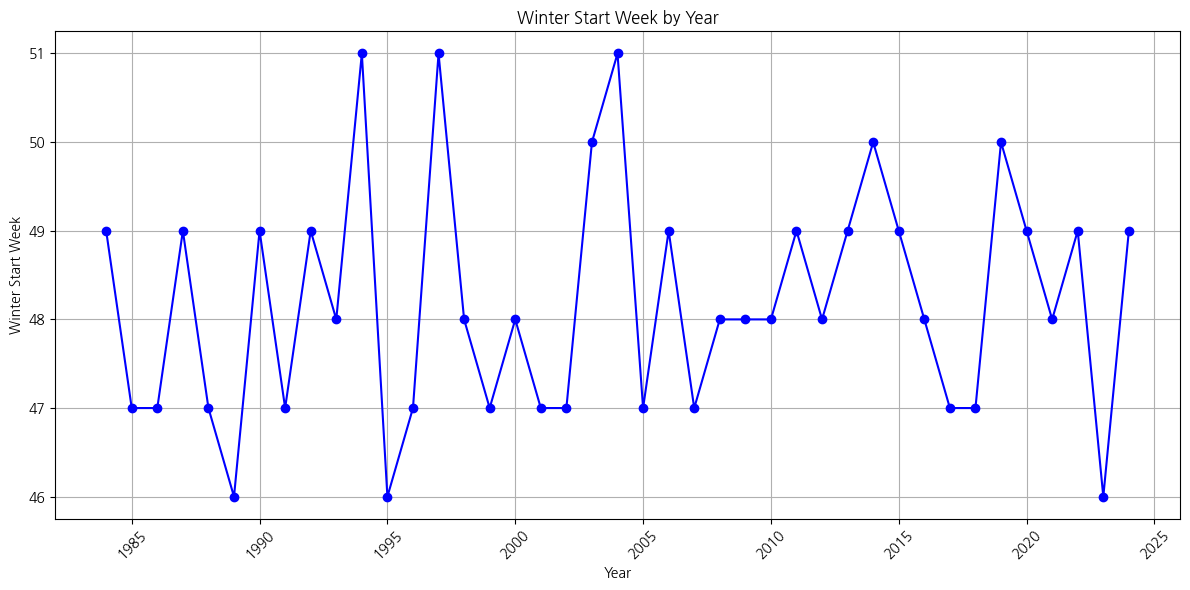

In [315]:
# 겨울 시작 주차(winter_start_week)를 기반으로 연도별 주차 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(df_winter_start['year'], df_winter_start['week'], marker='o', color='blue')

# 그래프 제목과 축 레이블 설정
plt.title("Winter Start Week by Year")
plt.xlabel("Year")
plt.ylabel("Winter Start Week")

# x축 라벨 45도 회전
plt.xticks(rotation=45)

# 그리드 추가
plt.grid(True)
plt.savefig('winter_start.png', dpi=300, transparent=True)

# 그래프 출력
plt.tight_layout()
plt.show()


In [316]:
# df_solar_short 겨울 시작일 데이터를 연도별로 병합
start_week = df_winter_start[['year', 'week']]  # 겨울 시작 주차


# 연도별 태양 에너지와 겨울 시작 주차 병합
df_combined = pd.merge(df_solar_short, start_week, left_on="year", right_on="year", how="inner")


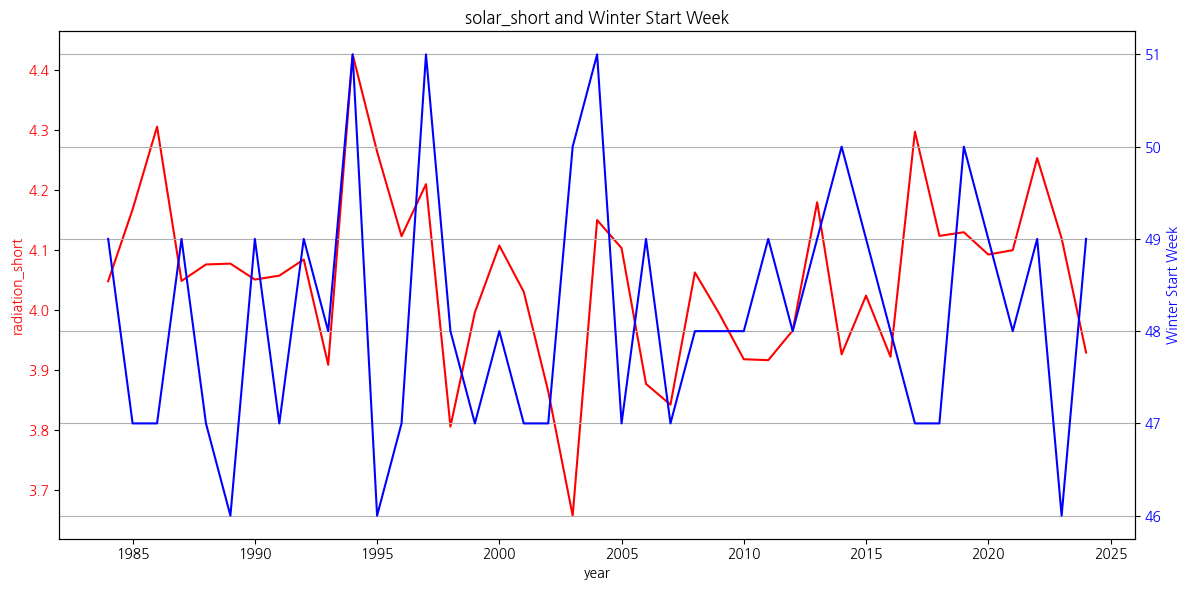

In [317]:
# 그래프 그리기 - 태양 에너지와 겨울 시작 주차 비교
fig, ax1 = plt.subplots(figsize=(12, 6))

# solar_short (왼쪽 y축)
ax1.set_xlabel("year")
ax1.set_ylabel("radiation_short", color="red")
ax1.plot(df_combined["year"], df_combined["radiation_short"], color="red")
ax1.tick_params(axis="y", labelcolor="red")

# 겨울 시작 주차 (오른쪽 y축)
ax2 = ax1.twinx()
ax2.set_ylabel("Winter Start Week", color="blue")
ax2.plot(df_combined["year"], df_combined["week"], color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

# 제목 및 레이아웃 설정
plt.title("solar_short and Winter Start Week")
# 그리드 추가
plt.grid(True)
plt.savefig('solar_short.png', dpi=300, transparent=True)
fig.tight_layout()
plt.show()

In [318]:
corr = df_combined[['radiation_short', 'week']].corr()
cov = df_combined[['radiation_short', 'week']].cov()
print(corr)
print(cov)

                 radiation_short      week
radiation_short         1.000000 -0.007132
week                   -0.007132  1.000000
                 radiation_short      week
radiation_short         0.022335 -0.001434
week                   -0.001434  1.810976


In [319]:
df_winter_start['week'].mean()

np.float64(48.19512195121951)

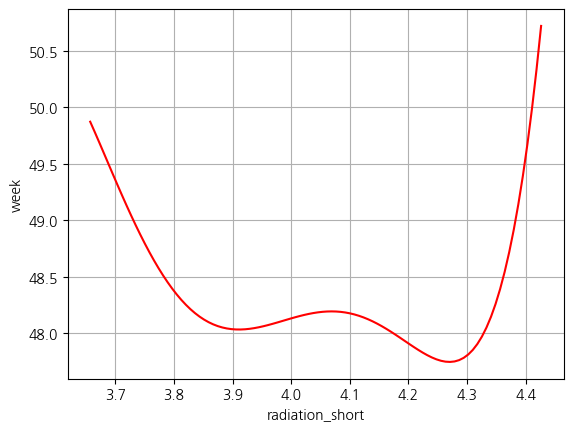

In [320]:
# 다항 회귀
# x: radiation_short, y: week
x = df_combined['radiation_short']
y = df_combined['week']
function = np.polyfit(x, y, 5)
poly_eq = np.poly1d(function)
# 예측값
xs=np.linspace(x.min(),x.max(),100)
y_pred = poly_eq(xs)
plt.plot(xs, y_pred, color='red')
plt.xlabel('radiation_short')
plt.ylabel('week')
plt.grid()
plt.savefig('short.png', dpi=300, transparent=True)
plt.show()


In [321]:
# solar_long
# 연도별 태양 에너지와 겨울 시작 주차 병합
df_combined = pd.merge(df_solar_long, start_week, left_on="year", right_on="year", how="inner")

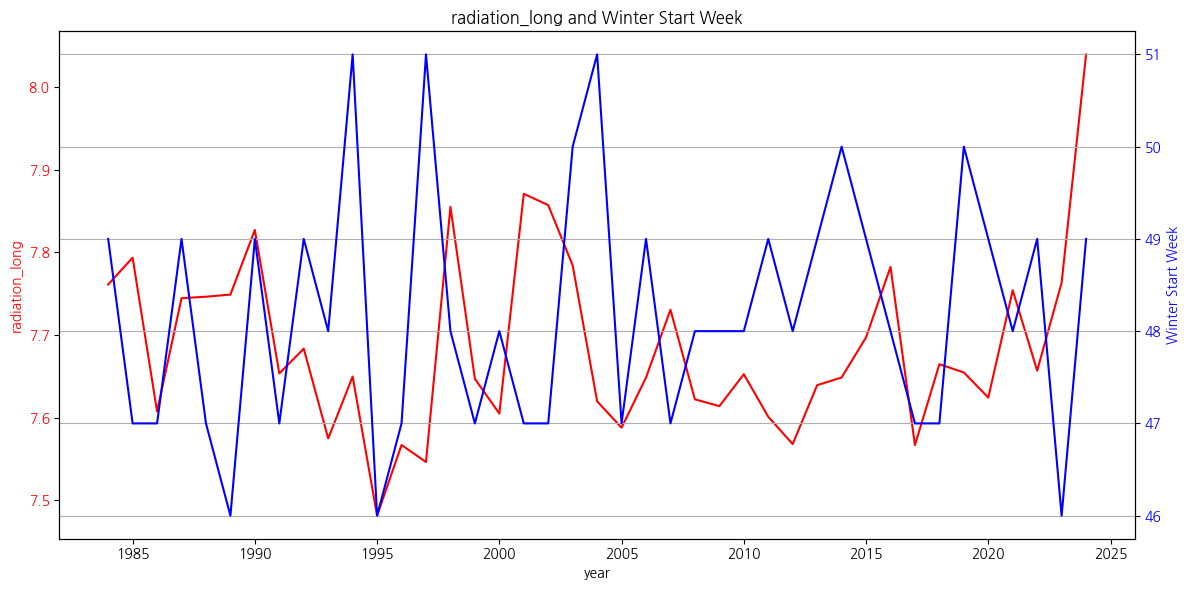

In [322]:
# 그래프 그리기 - 태양 에너지와 겨울 시작 주차 비교
fig, ax1 = plt.subplots(figsize=(12, 6))

# 태양 복사량 (왼쪽 y축)
ax1.set_xlabel("year")
ax1.set_ylabel("radiation_long", color="red")
ax1.plot(df_combined["year"], df_combined["radiation_long"], color="red")
ax1.tick_params(axis="y", labelcolor="red")

# 겨울 시작 주차 (오른쪽 y축)
ax2 = ax1.twinx()
ax2.set_ylabel("Winter Start Week", color="blue")
ax2.plot(df_combined["year"], df_combined["week"], color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

# 제목 및 레이아웃 설정
plt.title("radiation_long and Winter Start Week")
plt.grid(True)
plt.savefig('solar_long.png', dpi=300, transparent=True)
fig.tight_layout()
plt.show()

In [323]:
print('장파 공분산')
corr = df_combined[['radiation_long', 'week']].corr()
cov = df_combined[['radiation_long', 'week']].cov()
print(corr)
print(cov)

장파 공분산
                radiation_long      week
radiation_long        1.000000 -0.038494
week                 -0.038494  1.000000
                radiation_long      week
radiation_long        0.011833 -0.005635
week                 -0.005635  1.810976


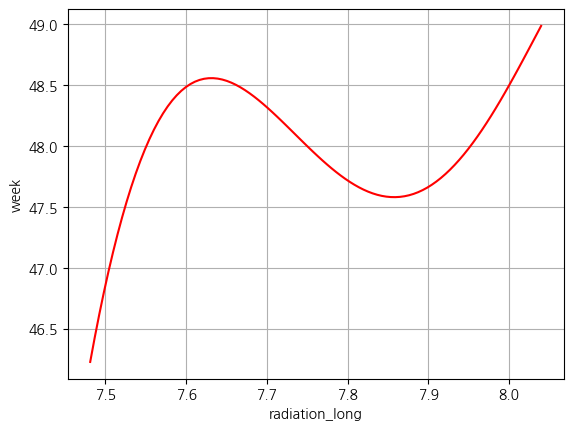

In [324]:
# x: radiation_long, y: week
x = df_combined['radiation_long']
y = df_combined['week']
function = np.polyfit(x, y, 5)
poly_eq = np.poly1d(function)
# 예측값
xs=np.linspace(x.min(),x.max(),100)
y_pred = poly_eq(xs)
plt.plot(xs, y_pred, color='red')
plt.xlabel('radiation_long')
plt.ylabel('week')
plt.grid()
plt.savefig('long.png', dpi=300, transparent=True)
plt.show()

[2.20583208e-04 7.24423870e+00]


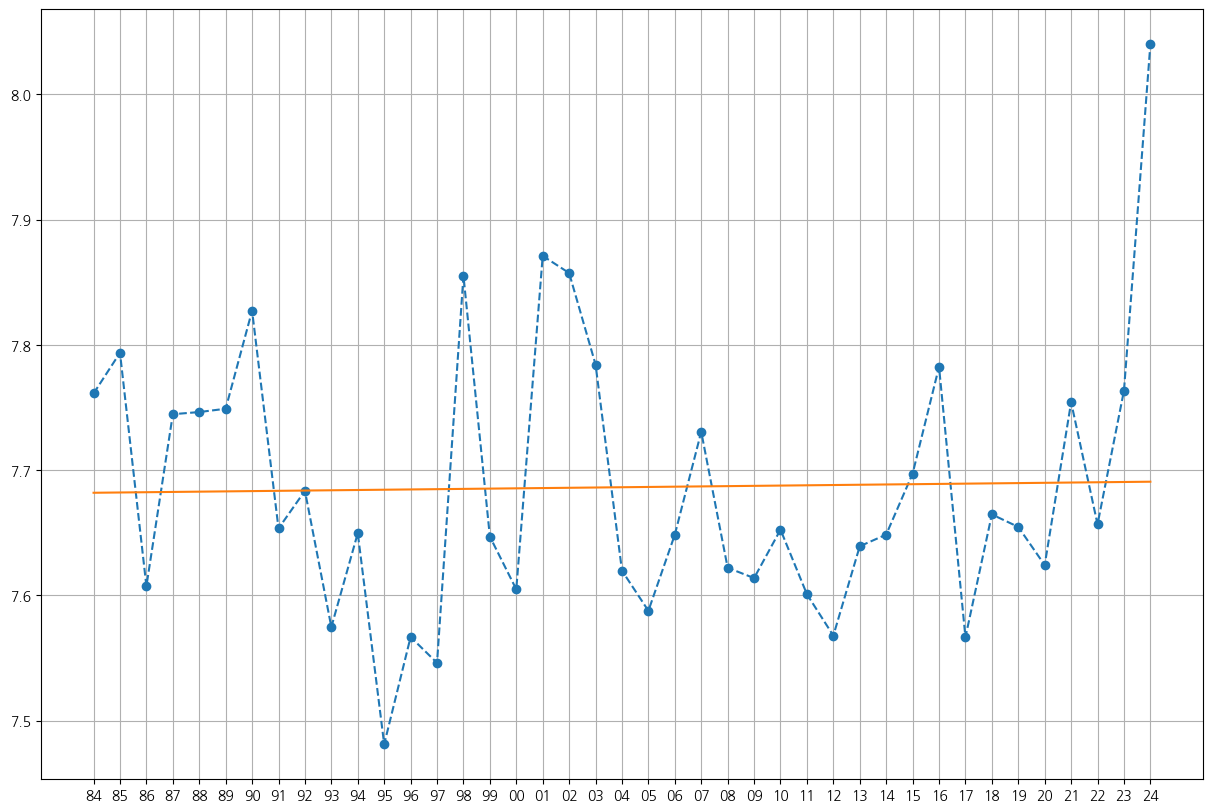

In [325]:
plt.figure(figsize=(15,10))
xs=[str(x)[-2:] for x in df_combined['year']]
plt.plot(df_combined['year'],df_combined['radiation_long'],'o--')
a=np.polyfit(df_combined['year'],df_combined['radiation_long'],1)
print(a)
f=np.poly1d(a)
plt.plot(df_combined['year'],f(df_combined['year']))
plt.xticks(df_combined['year'],xs)
plt.grid()
plt.show()

    year  radiation_long  week
13  1997        7.546082    51
14  1998        7.855205    48
15  1999        7.646904    47
16  2000        7.604754    48
17  2001        7.870986    47
18  2002        7.857288    47
19  2003        7.784247    50
20  2004        7.619699    51
21  2005        7.587644    47
22  2006        7.648411    49


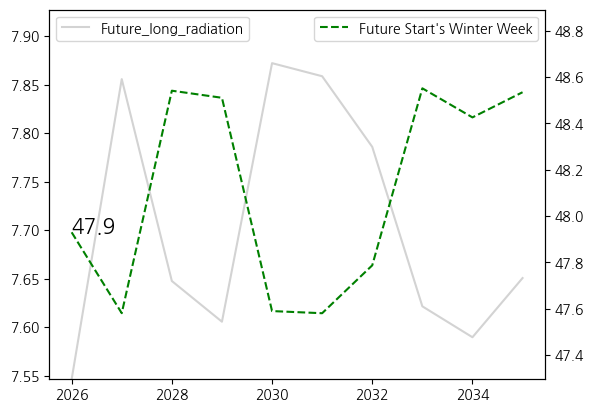

In [326]:
futureDF=df_combined[(df_combined['year']>=1997) & (df_combined['year']<=2006)]
print(futureDF)
# 증가량: 2.20583208e-04
long=futureDF['radiation_long']
#장파 에너지 증가량 계산
#매년 선형적으로 증가한다고 가정
future_long_rad=[x+ y*z for x,y,z  in zip(long,[2.20583208e-04]*len(long),range(1,len(long)+1))]
plt.plot(range(2026,2036),future_long_rad,label='Future_long_radiation',color='lightgrey')
plt.ylim(min(future_long_rad),max(future_long_rad)*1.007)
plt.legend(loc=2)

a=plt.twinx()
ys=poly_eq(future_long_rad)
a.set_ylim(min(ys)*0.994,max(ys)*1.007)
xs=range(2026,2036)
a.plot(xs,ys,'g--',label="Future Start's Winter Week")
a.legend(loc=1)
#plt.axhline(poly_eq(future_long_rad[0]))
plt.text(2026,poly_eq(future_long_rad[0]),s=round(poly_eq(future_long_rad[0]),1),fontsize=15)

plt.savefig('예측.png', dpi=300, transparent=True)
plt.show()

In [ ]:
futureDF=df_combined[(df_combined['year']>=1997) & (df_combined['year']<=2006)]
print(futureDF)
# 증가량: 2.20583208e-04
long=futureDF['radiation_long']
#장파 에너지 증가량 계산
#매년 선형적으로 증가한다고 가정
future_long_rad=[x+ y*z for x,y,z  in zip(long,[2.20583208e-04]*len(long),range(1,len(long)+1))]
plt.plot(range(2026,2036),future_long_rad,label='Future_long_radiation',color='lightgrey')
plt.ylim(min(future_long_rad),max(future_long_rad)*1.007)
plt.legend(loc=2)

a=plt.twinx()
ys=poly_eq(future_long_rad)
a.set_ylim(min(ys)*0.994,max(ys)*1.007)
xs=range(2026,2036)
a.plot(xs,ys,'g--',label="Future Start's Winter Week")
a.legend(loc=1)
#plt.axhline(poly_eq(future_long_rad[0]))
plt.text(2026,poly_eq(future_long_rad[0]),s=round(poly_eq(future_long_rad[0]),1),fontsize=15)

plt.savefig('예측.png', dpi=300, transparent=True)
plt.show()

In [328]:
print(df_winter_start['week'].mean())
ys.mean()

48.19512195121951


np.float64(48.10304291974753)